# Actor processing

In [1]:
import pandas as pd
import numpy as np
import json
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import copy
from collections import Counter
import math
import os

%matplotlib inline

/Users/star/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## 1.Load the supplied dataset
We first start by loading supplied datasets.

In [2]:
DATA_PATH = "./MovieSummaries/"

#Path to the referenced dataset
NEW_DATA_PATH = "./ExpandedData/"

#Normalizing the column names of the dataframe
movie_columns = ['WID', 'FID', 'MovieName', 'MovieReleaseDate', 'MovieBoxOfficeRevenue', \
                 'MovieRuntime', 'MovieLanguages', 'MovieCountries', 'MovieGenres']

characters_columns = ['WID','FID','MovieReleaseDate','CharacterName','ActorDOB','ActorGender',\
                      'ActorHeight','ActorEthnicity','ActorName','ActorAgeAtMovieRelease',\
                      'CharacterActorMapID','CharacterID','ActorID']

In [3]:
#Load two dataframes
movies = pd.read_csv(DATA_PATH+"movie.metadata.tsv", sep='\t', names=movie_columns)
characters = pd.read_csv(DATA_PATH+"character.metadata.tsv", sep='\t', names=characters_columns)

## 2.  Basic cleaning
We want to study the transformation of actors, and we clean the data in two separate tables according to the needs of our study.  
Let's start with the charcters dataframe, which is the most important for us.

### 2.1 Characters dataframe

In [4]:
#Checking samples and try to find problems
characters.sample(10)

,WID,FID,MovieReleaseDate,CharacterName,ActorDOB,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAgeAtMovieRelease,CharacterActorMapID,CharacterID,ActorID
119422,18681545,/m/04gk3mv,1996-11-29,Rektor Jansson,1950-02-05,M,NaN,NaN,Claes Månsson,46.0,/m/0jycypq,/m/0jycymy,/m/0cr642c
300074,23244306,/m/0661b1v,1987-06-02,NaN,NaN,NaN,NaN,NaN,Michele Marsh,NaN,/m/0gd207r,NaN,/m/0gbxlvr
72745,31802969,/m/0bcwhlw,2010-04-24,Mr. Tootsie Roll,NaN,M,NaN,NaN,Yero Brown,NaN,/m/0c1d6v0,/m/0c1d6v3,/m/0c1d6vb
304055,5901847,/m/0fcpm2,1969,Jadhav Patel,NaN,M,NaN,NaN,Sadhu Meher,NaN,/m/0h73q94,/m/0h73q96,/m/0jtlqk
42140,7432079,/m/0kv7ck,1979-02-09,Carmel,1967-06-29,F,1.6500,NaN,Melora Hardin,11.0,/m/04d910w,/m/0h2_cj9,/m/05xpms
70712,1118829,/m/047nfz,1989-07-31,Garry Buckman-Lampkin,1974-10-28,M,1.7300,/m/041rx,Joaquin Phoenix,14.0,/m/0k1rjp,/m/02nwkrb,/m/018db8
412833,22568371,/m/05zwx1g,2002,Thulasi,1976-09-16,F,NaN,/m/0dryh9k,Meena,25.0,/m/062y59z,/m/0hb8y0c,/m/046rfv
318583,32152754,/m/0gx09l1,2011-07-08,LN Tandon,NaN,M,NaN,/m/0dryh9k,Rajesh Sharma,NaN,/m/0h81ryt,/m/0h81ryw,/m/0cmlvrv
424652,13278422,/m/03c075w,2008-01-12,Krishna 'Kittu',1968-01-26,M,1.8288,/m/09m6hr,Ravi Teja,39.0,/m/0cs1gmz,/m/0h2z4gr,/m/0fb_fx
333276,3943529,/m/0b7ylp,2003-09-11,NaN,NaN,M,NaN,NaN,Claus Nissen,NaN,/m/0k52s2,NaN,/m/0k52r7


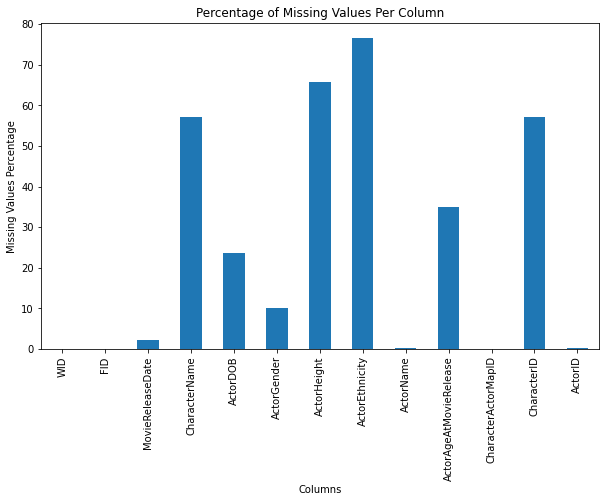

In [5]:
#View missing values for each column

# Counting the percentage of missing values 
missing_percentage = (characters.isnull().sum() / len(characters)) * 100

# Plot
plt.figure(figsize=(10, 6))
missing_percentage.plot(kind='bar')
plt.title('Percentage of Missing Values Per Column')
plt.xlabel('Columns')
plt.ylabel('Missing Values Percentage')
plt.show()

Combining the previous information and the questions to be analyzed, the following data were cleaned  
1. Remove rows with ActorName of NaN since the research question is actors' transformation.  
2. Unify the date format and deal with the wrong data  
3. Use movie release date - actor dob to make up for the missing actor age data  

#### 2.1.1 Remove rows with ActorName of NaN 

In [6]:
characters_drop = characters.dropna(subset=['ActorName']).copy()

#### 2.1.2 Unify the format of the date

In [7]:
characters_date_change = characters_drop.copy()
characters_date_change.loc[characters_date_change['MovieReleaseDate'] == '1010-12-02', 'MovieReleaseDate'] = '2010-12-02'
characters_date_change['MovieReleaseDate'] = pd.to_datetime(characters_date_change['MovieReleaseDate'], errors='coerce').dt.year
characters_date_change['ActorDOB'] = pd.to_datetime(characters_date_change['ActorDOB'], errors='coerce').dt.year

#Create a mask to mark rows with a birth date later than the release date (424rows)
mask = characters_date_change['ActorDOB'] > characters_date_change['MovieReleaseDate']

#invalid_rows = characters_data_change[mask]
#print(invalid_rows)

# Delete these rows
characters_date_change = characters_date_change[~mask]

#Check
characters_date_change[characters_date_change['ActorDOB'] > characters_date_change['MovieReleaseDate']]

,WID,FID,MovieReleaseDate,CharacterName,ActorDOB,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAgeAtMovieRelease,CharacterActorMapID,CharacterID,ActorID


In [8]:
characters_date_change.info()

<class 'pandas.core.frame.DataFrame'>
Index: 449258 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   WID                     449258 non-null  int64  
 1   FID                     449258 non-null  object 
 2   MovieReleaseDate        273013 non-null  float64
 3   CharacterName           192416 non-null  object 
 4   ActorDOB                329691 non-null  float64
 5   ActorGender             404867 non-null  object 
 6   ActorHeight             154756 non-null  float64
 7   ActorEthnicity          106016 non-null  object 
 8   ActorName               449258 non-null  object 
 9   ActorAgeAtMovieRelease  292360 non-null  float64
 10  CharacterActorMapID     449258 non-null  object 
 11  CharacterID             192424 non-null  object 
 12  ActorID                 449258 non-null  object 
dtypes: float64(4), int64(1), object(8)
memory usage: 48.0+ MB


#### 2.1.3.Supplementing missing data on actors' ages with movie release dates - actors' birth dates

In [9]:


# Find rows where age is missing but date of birth and date of appearance are not missing
characters_age_change = characters_date_change.copy()
mask2 = characters_age_change['ActorAgeAtMovieRelease'].isnull() & \
        characters_age_change['ActorDOB'].notnull() & \
        characters_age_change['MovieReleaseDate'].notnull() \


# Calculate age for these rows
characters_age_change.loc[mask2, 'ActorAgeAtMovieRelease'] = (
                                        characters_age_change.loc[mask2, 'MovieReleaseDate'] - \
                                        characters_age_change.loc[mask2, 'ActorDOB']
                                                             )


# Show rows with updated age data（21036 rows updated）
characters_age_change[mask2]

,WID,FID,MovieReleaseDate,CharacterName,ActorDOB,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAgeAtMovieRelease,CharacterActorMapID,CharacterID,ActorID
86,31983669,/m/0g4_n3m,1931.0,"Tomka Zhigan, leader of the wild boys",1899.0,M,NaN,NaN,Mikhail Zharov,32.0,/m/0g4_ndp,/m/0g4_nbx,/m/07m08h
93,31983669,/m/0g4_n3m,1931.0,NaN,1887.0,M,NaN,NaN,Vladimir Uralsky,44.0,/m/0g4_nfp,NaN,/m/0jt1q2
97,31983669,/m/0g4_n3m,1931.0,Nikolai Sergeiev,1899.0,M,NaN,NaN,Nikolai Batalov,32.0,/m/0g4_nd9,/m/0g4_nbj,/m/0jt1lz
98,17715326,/m/047t9rb,1935.0,NaN,1888.0,M,NaN,NaN,Graham McNamee,47.0,/m/0jz1t0_,NaN,/m/07g4h_
195,14631844,/m/03grb4v,1917.0,NaN,1891.0,M,NaN,NaN,Wallace Reid,26.0,/m/0cg2rbf,NaN,/m/03q8vb
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450605,7762741,/m/0kvgqq,1914.0,NaN,1883.0,M,NaN,NaN,Jack Richardson,31.0,/m/09h_33r,NaN,/m/0ks01m
450606,7762741,/m/0kvgqq,1914.0,NaN,1871.0,M,NaN,NaN,Harry von Meter,43.0,/m/09h_33l,NaN,/m/0kr_7z
450607,21975745,/m/05p4tmc,1938.0,NaN,1894.0,M,NaN,NaN,Billy Bletcher,44.0,/m/0gw3w0l,NaN,/m/06f_qn
450611,15567100,/m/03mfb7j,1922.0,NaN,1881.0,M,NaN,NaN,Duke R. Lee,41.0,/m/040nz44,NaN,/m/03c74h7


In [10]:
#Clearing age is negative(199rows,MovieReleaseDate,ActorDOBat least one missing )
negative_age_mask = characters_date_change['ActorAgeAtMovieRelease'] < 0
indices_to_drop = characters_date_change[negative_age_mask].index

#Delete these rows
characters_date_change = characters_date_change.drop(indices_to_drop)

#Check
characters_date_change[characters_date_change['ActorAgeAtMovieRelease'] < 0]

,WID,FID,MovieReleaseDate,CharacterName,ActorDOB,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAgeAtMovieRelease,CharacterActorMapID,CharacterID,ActorID


### 2.2 Movies Dataframe
Let's move on to the movies dataframe.

In [11]:
#Checking samples and try to find problems
movies.head(10)

,WID,FID,MovieName,MovieReleaseDate,MovieBoxOfficeRevenue,MovieRuntime,MovieLanguages,MovieCountries,MovieGenres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant..."
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ..."
8,9997961,/m/06_y2j7,Contigo y aquí,1974,NaN,NaN,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0jgd"": ""Argentina""}","{""/m/04t36"": ""Musical"", ""/m/07s9rl0"": ""Drama"",..."
9,2345652,/m/075f66,City of the Dead,1960,NaN,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/0fdjb"": ""Supernatur..."


In [12]:
import json
#Processing format
movies_format = movies.copy()

movies_format['MovieLanguages'] = movies_format['MovieLanguages'].apply(lambda x: "".join(list(json.loads(x).values())))
movies_format['MovieCountries'] = movies_format['MovieCountries'].apply(lambda x: "".join(list(json.loads(x).values())))
movies_format['MovieGenres'] = movies_format['MovieGenres'].apply(lambda x: ",".join(list(json.loads(x).values())))
movies_format['MovieGenres'] = movies_format['MovieGenres'].str.split(',')
movies_format.head()

,WID,FID,MovieName,MovieReleaseDate,MovieBoxOfficeRevenue,MovieRuntime,MovieLanguages,MovieCountries,MovieGenres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,English Language,United States of America,"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,English Language,United States of America,"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,Norwegian Language,Norway,"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,English Language,United Kingdom,"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,German Language,Germany,[Drama]


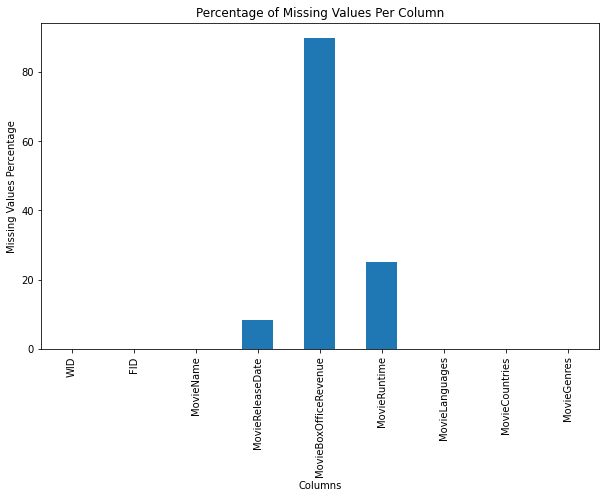

In [13]:
#View missing values for each column

# Counting the percentage of missing values 
missing_percentage = (movies_format.isnull().sum() / len(movies)) * 100

# Plot
plt.figure(figsize=(10, 6))
missing_percentage.plot(kind='bar')
plt.title('Percentage of Missing Values Per Column')
plt.xlabel('Columns')
plt.ylabel('Missing Values Percentage')
plt.show()

To investigate the evolution of actors' roles across different movie genres, we perform the following key operations on the movie dataset:

Quantify the occurrence of genre terms, refine the dataset's format, identify principal genres, and apply additional filters as needed.
Standardize the date formatting and rectify any discrepancies.
Integrate supplementary datasets to compensate for the significant gaps in box office information. Post-processing, introduce new columns to adjust for inflation effects.

#### 2.2.1 Handling the genres

We first analyzed the frequency of occurrence for various genres and selected 18 representative categories.  

Then, we carried out manual screening and data visualization and we consolidated some of the categories with reference to Wikipedia's definitions.

In [14]:
#Statistical word frequency
movies_format['MovieGenres'] = movies_format['MovieGenres'].apply(lambda x: x if isinstance(x, list) else [])
categories = movies_format['MovieGenres'].explode().value_counts()
sorted_category_counts = categories.sort_values(ascending=False)
print(sorted_category_counts.head(50))

MovieGenres
Drama                     34007
Comedy                    16349
Romance Film              10234
Black-and-white            9094
Action                     8798
Thriller                   8744
Short Film                 8141
World cinema               7155
Crime Fiction              6948
Indie                      6897
Documentary                5630
Horror                     5280
Silent film                5250
Adventure                  4963
Family Film                4598
Action/Adventure           4561
Comedy film                4362
Musical                    4160
Animation                  3534
Romantic drama             3372
Mystery                    3195
Science Fiction            3052
Fantasy                    2820
Romantic comedy            2680
War film                   2652
Japanese Movies            2322
                           2294
Western                    2226
Crime Thriller             2122
Period piece               1758
Comedy-drama               1

In [15]:
#Further cleaning of MovieGenres accoding to our observation

#Common genres of our selection
selected_genres = ['Comedy', 'Drama', 'Romance', 'Action', 'Thriller', 'Crime', 'Documentary',\
                   'Horror', 'Adventure', 'Musical' , 'Animation', 'Science Fiction', 'Fantasy',\
                   'Western', 'War film', 'Sports', 'Hisorty', 'Detective']

# clean the genre,use deepcopy to make sure there will be no change in previous dataframe
genre = [copy.deepcopy(x) for x in movies_format["MovieGenres"].values]
movie_genres_selected = []

#Unify genres‘ data and filter the “drama” genres
for line in genre:
    selected = []
    for g in line:
        if g in selected_genres:
            selected.append(g)
        elif g in ['Romance Film', 'Romantic drama', 'Romantic comedy']:
            selected.append('Romance')
        elif g in ['Crime Fiction', 'Crime Thriller', 'Crime Drama']:
            selected.append('Crime')
        elif g in ['Action/Adventure']:
            selected.append('Adventure')
            selected.append('Action')
        elif g in ['Black comedy', 'Comedy film', 'Comedy-drama', 'Sex comedy', 'Comedy of manners', 'Musical comedy', 'Horror Comedy', 'Fantasy Comedy']:
            selected.append('Comedy')
        elif g in ['Action Thrillers','Wuxia', 'Martial Arts Film']:
            selected.append('Action')
            selected.append('Thriller')
        elif g in ['Detective fiction']:
            selected.append('Detective')
        elif g in ['Historical drama', 'Historical fiction']:
            selected.append('History')
        elif g in ['Anime']:
            selected.append('Animation')
                
    
    # remove the duplicates and sort list of genres by the initial letter
    sorted_set_genres = sorted(set(selected))
    
    movie_genres_selected.append(sorted_set_genres)
    
movies_genres_filter = movies_format.copy()
movies_genres_filter["MovieGenresSelected"] = movie_genres_selected

In [16]:
# calculate the proportion of empty selected genres
movies_genres_filter[movies_genres_filter["MovieGenresSelected"].map(len) == 0].shape[0]/movies_genres_filter.shape[0]

0.11399420119646199

Our selection can cover 89% of the data.

In [17]:
# drop rows where there is no movie genre selected
movies_genres_clean = movies_genres_filter[movies_genres_filter["MovieGenresSelected"].map(len) > 0].copy()
movies_genres_clean.sample(10)

,WID,FID,MovieName,MovieReleaseDate,MovieBoxOfficeRevenue,MovieRuntime,MovieLanguages,MovieCountries,MovieGenres,MovieGenresSelected
43411,20467212,/m/04zzcfy,The Devil's Game,2008-01-31,10287987.0,116.0,,South Korea,"[Thriller, Drama]","[Drama, Thriller]"
42941,35013898,/m/0j632jy,Memoria negra,2006-10-20,NaN,97.0,Spanish Language,Spain,[Documentary],[Documentary]
32442,1766716,/m/05v7gb,Northland,1942,NaN,20.0,English Language,Canada,"[Short Film, Black-and-white, Documentary]",[Documentary]
66730,24128130,/m/06ztbtw,Don Muthu Swami,2008-05-23,NaN,114.0,Hindi Language,India,"[Bollywood, Musical, Comedy, World cinema]","[Comedy, Musical]"
23696,24239625,/m/07k55yb,Ogniomistrz Kaleń,1961,NaN,103.0,Polish Language,Poland,"[Drama, Black-and-white]",[Drama]
40336,34764141,/m/0j3dwp7,A Sacred Duty,2007-10,NaN,60.0,,,[Documentary],[Documentary]
57619,17487832,/m/04g0w0x,Star in the Night,1945-10-13,NaN,22.0,English Language,United States of America,"[Short Film, Drama, Black-and-white]",[Drama]
38402,26373700,/m/0bbzz40,The Dream,1966-07-14,NaN,93.0,,Yugoslavia,[War film],[War film]
171,19031505,/m/04jkr54,The Girl on the Pier,1953,NaN,65.0,English Language,United Kingdom,"[Crime Fiction, Drama]","[Crime, Drama]"
52898,12836960,/m/02x6zph,A Love Story,2007-08-15,NaN,NaN,Tagalog languageEnglish Language,PhilippinesMacau,"[Romance Film, Drama, Filipino Movies]","[Drama, Romance]"


In [18]:
movies_genres_clean[movies_genres_clean["MovieGenresSelected"].map(len) == 0]

,WID,FID,MovieName,MovieReleaseDate,MovieBoxOfficeRevenue,MovieRuntime,MovieLanguages,MovieCountries,MovieGenres,MovieGenresSelected


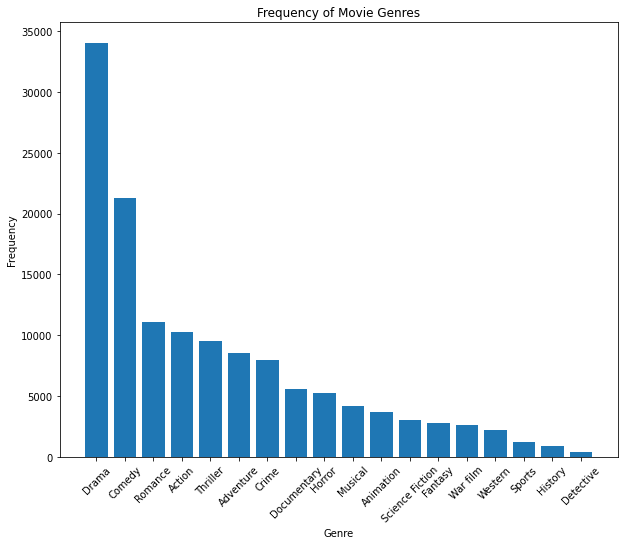

In [19]:
#Counting the frequency of every genre 

genre_counter = Counter()

# Iterate through each list in the column
for genre_list in movies_genres_clean['MovieGenresSelected']:
    genre_counter.update(genre_list)

# Converting word frequency results into a DataFrame
genre_frequency = pd.DataFrame(genre_counter.items(), columns=['Genre', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Plotting to show word frequency
plt.figure(figsize=(10, 8))
plt.bar(genre_frequency['Genre'], genre_frequency['Frequency'])
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.title('Frequency of Movie Genres')
plt.xticks(rotation=45)
plt.show()

1. The 'Drama' genre encompasses a wide range, and its prevalence complicates the characterization of an actor's career shifts. Consequently, we will retain 'Drama' only when it is not paired with any other genre.

2. Actors appearing in animated movies mostly partake through voice acting. Given that providing voice for animated action scenes is inherently different from performing in live-action action movies, we have decided to eliminate all rows associated with the animation genre from our database.

In [20]:
genre = [copy.deepcopy(x) for x in movies_genres_clean["MovieGenresSelected"].values]
movie_genres_drama_animation_del = []

# Keeping “Drama” only when drama appears alone, delete entire entry when “animation” exists
for line in genre:
    # If 'Animation' is in the line, do not add the line to the final list
    if 'Animation' in line:
        movie_genres_drama_animation_del.append([])
    else:
        # If 'Drama' is in the line alongside other genres, remove 'Drama'
        if len(line) > 1 and 'Drama' in line:
            line.remove('Drama')
        # Add the modified line to the final list
        movie_genres_drama_animation_del.append(line)

movies_genres_del = movies_genres_clean.copy()
movies_genres_del["MovieGenresFinal"] = movie_genres_drama_animation_del 

In [21]:
#Filter 
movies_genres_del_filter = movies_genres_del[movies_genres_del["MovieGenresFinal"].map(len) > 0].copy()

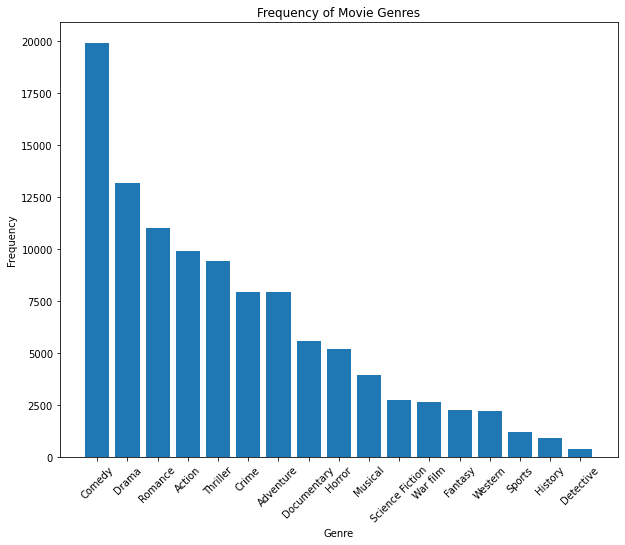

In [22]:
#Counting the frequency of every genre 

genre_counter = Counter()

# Iterate through each list in the column
for genre_list in movies_genres_del["MovieGenresFinal"]:
    genre_counter.update(genre_list)

# Converting word frequency results into a DataFrame
genre_frequency = pd.DataFrame(genre_counter.items(), columns=['Genre', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Plotting to show word frequency
plt.figure(figsize=(10, 8))
plt.bar(genre_frequency['Genre'], genre_frequency['Frequency'])
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.title('Frequency of Movie Genres')
plt.xticks(rotation=45)
plt.show()

#### 2.2.2 Unify the date format and deal with the wrong data

In [23]:
#Unify the date format(Harmonization of reservations by year)
movies_date_change = movies_genres_del_filter.copy()
movies_date_change.loc[movies_date_change['MovieReleaseDate'] == '1010-12-02', 'MovieReleaseDate'] = '2010-12-02'
movies_date_change['MovieReleaseDate'] = pd.to_datetime(movies_date_change['MovieReleaseDate'], errors='coerce').dt.year

#Change the type of the year to int
movies_date_change['MovieReleaseDate'] = movies_date_change['MovieReleaseDate'].dropna().astype(int)

In [24]:
movies_date_change.head(50)

,WID,FID,MovieName,MovieReleaseDate,MovieBoxOfficeRevenue,MovieRuntime,MovieLanguages,MovieCountries,MovieGenres,MovieGenresSelected,MovieGenresFinal
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,English Language,United States of America,"[Thriller, Science Fiction, Horror, Adventure,...","[Action, Adventure, Horror, Science Fiction, T...","[Action, Adventure, Horror, Science Fiction, T..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,NaN,95.0,English Language,United States of America,"[Mystery, Biographical film, Drama, Crime Drama]","[Crime, Drama]",[Crime]
2,28463795,/m/0crgdbh,Brun bitter,NaN,NaN,83.0,Norwegian Language,Norway,"[Crime Fiction, Drama]","[Crime, Drama]",[Crime]
3,9363483,/m/0285_cd,White Of The Eye,NaN,NaN,110.0,English Language,United Kingdom,"[Thriller, Erotic thriller, Psychological thri...",[Thriller],[Thriller]
4,261236,/m/01mrr1,A Woman in Flames,NaN,NaN,106.0,German Language,Germany,[Drama],[Drama],[Drama]
5,13696889,/m/03cfc81,The Gangsters,1913.0,NaN,35.0,Silent filmEnglish Language,United States of America,"[Short Film, Silent film, Indie, Black-and-whi...",[Comedy],[Comedy]
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,NaN,NaN,86.0,English Language,South Africa,"[Family Film, Fantasy, Adventure, World cinema]","[Adventure, Fantasy]","[Adventure, Fantasy]"
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938.0,3600000.0,106.0,English Language,United States of America,"[Musical, Comedy, Black-and-white]","[Comedy, Musical]","[Comedy, Musical]"
8,9997961,/m/06_y2j7,Contigo y aquí,NaN,NaN,NaN,Spanish Language,Argentina,"[Musical, Drama, Comedy]","[Comedy, Drama, Musical]","[Comedy, Musical]"
9,2345652,/m/075f66,City of the Dead,NaN,NaN,76.0,English Language,United Kingdom,"[Horror, Supernatural]",[Horror],[Horror]


#### 2.2.3 Handling the 'Revenue' column

In [25]:
movies_key = movies_date_change[movies_date_change['MovieBoxOfficeRevenue'].notna()]
movies_key.shape

(7998, 11)

In [26]:
extraMovieBoxOfficeRevenue=pd.read_pickle(NEW_DATA_PATH+"additional_revenue_data.pkl")

# Rename
extraMovieBoxOfficeRevenue.rename(columns={'freebase_movie_id': 'FID'}, inplace=True)
extraMovieBoxOfficeRevenue.rename(columns={'revenue': 'MovieBoxOfficeRevenue'}, inplace=True)
extraMovieBoxOfficeRevenue.head(10)

,FID,MovieBoxOfficeRevenue
0,/m/02pg45,4300000
1,/m/03dymt,12136938
2,/m/0dtfn,775398007
3,/m/01jrbb,940335536
4,/m/0bdjd,677945399
5,/m/0c0zq,356296601
6,/m/01lsl,23217674
7,/m/01m13b,40031879
8,/m/0125xq,263920180
9,/m/0d6b7,650422


In [27]:
# Merge based on FID
movies_revenue_merged_data = pd.merge(movies_date_change,extraMovieBoxOfficeRevenue[['FID', 'MovieBoxOfficeRevenue']], on='FID', how='left')

# Keep original data, append where missing
movies_revenue_merged_data['MovieBoxOfficeRevenue'] = movies_revenue_merged_data.apply(
    lambda row: row['MovieBoxOfficeRevenue_y'] if pd.isna(row['MovieBoxOfficeRevenue_x']) else row['MovieBoxOfficeRevenue_x'], axis=1
)

#Remove duplicates
movies_revenue_merged_data.drop(columns=['MovieBoxOfficeRevenue_x', 'MovieBoxOfficeRevenue_y'], inplace=True)

In [28]:
movies_key2 = movies_revenue_merged_data[movies_revenue_merged_data['MovieBoxOfficeRevenue'].notna()]
movies_key2.shape

(9795, 11)

In [29]:
# Number of supplements
number_supplements = len(movies_key2) - len(movies_key)
number_supplements

1797

In [30]:
# Inflation per country from 1960 to 2021
df_inflation = pd.read_csv(NEW_DATA_PATH+"inflation.csv", header=2)
df_inflation = df_inflation.iloc[:,0:-1]
df_inflation.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Aruba,ABW,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,0.627472,-2.372065,0.421441,0.474764,-0.931196,-1.028282,3.626041,4.257462,NaN,NaN
1,Africa Eastern and Southern,AFE,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,9.158707,5.750981,5.370290,5.250171,6.571396,6.399343,4.720811,4.120246,5.404815,7.240978
2,Afghanistan,AFG,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,6.441213,7.385772,4.673996,-0.661709,4.383892,4.975952,0.626149,2.302373,NaN,NaN
3,Africa Western and Central,AFW,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,4.578375,2.439201,1.758052,2.130268,1.494564,1.764635,1.784050,1.758565,2.492522,3.925603
4,Angola,AGO,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,10.277905,8.777814,7.280387,9.150372,30.695313,29.843587,19.628608,17.081215,NaN,NaN


In [31]:
# Inflation in the USA from 1960 to 2021 as the revenue and budget are calculated in US dollars
usa_inflation = df_inflation[df_inflation['Country Code'] == 'USA']

# Create the inflation coefficients per year 
inflation_coef = np.zeros(63)
inflation_coef[0] = 1
for i in range(62):
    year = i + 1960
    inflation_coef[i+1] = inflation_coef[i] * (1 + float(usa_inflation[str(year)].iloc[0])/100)
print(inflation_coef[-1])

9.295703259005146


In [32]:
# Function that gets the coefficient coeff according to the year
def get_inflation(year):
    if isinstance(year, int) :
        x = year-1959
        if x >= 0 and x < len(inflation_coef) :
            return inflation_coef[-1]/inflation_coef[x]
    return float('nan')

# Add the inflation coeff column to the dataframe 
movies_coeff_add = movies_revenue_merged_data.copy()
movies_coeff_add["InflationCoeff"] = movies_coeff_add["MovieReleaseDate"].apply(get_inflation)

In [33]:
movies_revenue_inflation = movies_coeff_add . copy()
movies_revenue_inflation["inflation corrected revenue"] = movies_revenue_inflation['MovieBoxOfficeRevenue'] * movies_revenue_inflation["MovieReleaseDate"].apply(get_inflation)

## 3. Merge two dataframes and load external datasets
We merged the processed `characters` and `movies` and introduced a new dataset:  
1.IMDB rating  
2.Actor awards from the four major film festivals （Cannes, Berlin, Venice, Oscar）  

They will help us for subsequent analysis in causes and consequences of actor transformation.

### 3.1 Merge two main dataframes

In [34]:
#merge the processed two dataframes
characters_movies_merge = pd.merge(characters_date_change , movies_date_change, how='inner', on=["WID", "FID", "MovieReleaseDate"])
characters_movies_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413660 entries, 0 to 413659
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   WID                     413660 non-null  int64  
 1   FID                     413660 non-null  object 
 2   MovieReleaseDate        251724 non-null  float64
 3   CharacterName           178646 non-null  object 
 4   ActorDOB                301676 non-null  float64
 5   ActorGender             371039 non-null  object 
 6   ActorHeight             144323 non-null  float64
 7   ActorEthnicity          97643 non-null   object 
 8   ActorName               413660 non-null  object 
 9   ActorAgeAtMovieRelease  268625 non-null  float64
 10  CharacterActorMapID     413660 non-null  object 
 11  CharacterID             178654 non-null  object 
 12  ActorID                 413660 non-null  object 
 13  MovieName               413660 non-null  object 
 14  MovieBoxOfficeRevenu

In [35]:
characters_movies_merge[characters_movies_merge["MovieGenresFinal"].isnull()]["MovieGenresFinal"]

Series([], Name: MovieGenresFinal, dtype: object)

In [36]:
#Changing data types to int to harmonize with external datasets and facilitate merging
characters_movies_date_change_type = characters_movies_merge.copy()
characters_movies_date_change_type['MovieReleaseDate'] = characters_movies_date_change_type['MovieReleaseDate'].fillna(0).astype(int)
characters_movies_date_change_type['ActorDOB'] = characters_movies_date_change_type['ActorDOB'].fillna(0).astype(int)

characters_movies_date_change_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413660 entries, 0 to 413659
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   WID                     413660 non-null  int64  
 1   FID                     413660 non-null  object 
 2   MovieReleaseDate        413660 non-null  int64  
 3   CharacterName           178646 non-null  object 
 4   ActorDOB                413660 non-null  int64  
 5   ActorGender             371039 non-null  object 
 6   ActorHeight             144323 non-null  float64
 7   ActorEthnicity          97643 non-null   object 
 8   ActorName               413660 non-null  object 
 9   ActorAgeAtMovieRelease  268625 non-null  float64
 10  CharacterActorMapID     413660 non-null  object 
 11  CharacterID             178654 non-null  object 
 12  ActorID                 413660 non-null  object 
 13  MovieName               413660 non-null  object 
 14  MovieBoxOfficeRevenu

### 3.2 Import IMDB rating and the number of votes 

In [37]:
#Read two tables (IMDB ratings and IMDB movies basic info) and merge the desired info together
IMDB_rating = pd.read_csv(NEW_DATA_PATH+'title.ratings.tsv', sep='\t')
IMDB_rating.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2006
1,tt0000002,5.8,269
2,tt0000003,6.5,1909
3,tt0000004,5.5,178
4,tt0000005,6.2,2689


In [38]:
IMDB_name = pd.read_csv(NEW_DATA_PATH+'title.basics.tsv', sep='\t')
IMDB_name.head()

<ipython-input-38-9fd7d296c54b>:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  IMDB_name = pd.read_csv(NEW_DATA_PATH+'title.basics.tsv', sep='\t')


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [39]:
#Delete unneeded columns
IMDB_name_delete = IMDB_name[['tconst', 'primaryTitle','startYear']].copy()
IMDB_merge = IMDB_name_delete.merge(IMDB_rating, on='tconst')
IMDB_merge.isna()['tconst'].unique()
IMDB_merge.head()

,tconst,primaryTitle,startYear,averageRating,numVotes
0,tt0000001,Carmencita,1894,5.7,2006
1,tt0000002,Le clown et ses chiens,1892,5.8,269
2,tt0000003,Pauvre Pierrot,1892,6.5,1909
3,tt0000004,Un bon bock,1892,5.5,178
4,tt0000005,Blacksmith Scene,1893,6.2,2689


In [40]:
#View startyear data
IMDB_merge['startYear'].unique()

array(['1894', '1892', '1893', '1895', '1896', '1898', '1897', '1900',
       '1899', '1901', '1902', '1903', '1904', '1912', '1907', '1905',
       '1906', '1908', '1910', '1909', '1990', '1914', '1911', '1913',
       '1919', '1916', '1917', '1915', '1918', '1936', '1925', '1922',
       '1920', '1921', '1923', '1924', '2021', '1927', '1929', '2000',
       '1926', '1993', '1935', '1928', '1942', '1930', '1931', '1932',
       '1939', '1937', '1950', '1933', '1938', '1951', '1934', '1945',
       '1946', '1940', '1944', '1949', '1947', '1941', '1952', '1970',
       '1957', '1943', '1959', '1948', '1994', '2001', '1953', '1954',
       '1965', '1983', '1980', '1973', '1961', '1995', '1955', '1962',
       '1958', '1956', '1960', '1977', '1964', '2012', '1967', '1963',
       '1988', '1968', '1971', '1969', '1972', '1966', '1976', '1979',
       '2016', '1974', '1981', '2020', '1978', '1989', '2014', '1975',
       '1986', '1985', '1987', '2010', '2018', '1996', '1992', '2023',
      

In [41]:
# Handling of outliers'\\N'
IMDB_merge['startYear'] = IMDB_merge['startYear'].replace('\\N', 0)

In [42]:
#change its type to int, in order to merge with our datasets
IMDB_merge['startYear'] = IMDB_merge['startYear'].fillna(0).astype(int)

In [43]:
duplicates = IMDB_merge.duplicated(subset=['primaryTitle', 'startYear'], keep=False)

# Filter your DataFrame
duplicate_rows = IMDB_merge[duplicates]
duplicate_rows.head(20)

,tconst,primaryTitle,startYear,averageRating,numVotes
125,tt0000127,Les tribulations d'un concierge,1896,4.4,27
174,tt0000177,The Burglar on the Roof,1898,4.6,249
234,tt0000279,Buffalo Bill's Wild West Parade,1900,4.3,25
235,tt0000280,Buffalo Bill's Wild West Parade,1900,4.6,25
319,tt0000471,Uncle Tom's Cabin,1903,5.2,520
320,tt0000472,Uncle Tom's Cabin,1903,6.3,23
394,tt0000630,Hamlet,1908,2.9,27
469,tt0000754,Romeo and Juliet,1908,7.2,63
588,tt0000950,Macbeth,1909,4.0,16
665,tt0001083,The Violin Maker of Cremona,1909,5.0,145


In [44]:
# Group by 'primaryTitle' and 'startYear' and calculate the mean of 'averageRating' and sum of 'votenum'
new_IMDB_df = IMDB_merge.groupby(['primaryTitle', 'startYear']).agg({
    'averageRating': 'mean',
    'numVotes': 'sum'
}).reset_index()


# Display the first few rows to check
new_IMDB_df.head()

,primaryTitle,startYear,averageRating,numVotes
0,!Next?,1994,5.1,20
1,!Que ve el Bisbe!,2011,6.2,12
2,!Women Art Revolution,2010,6.8,256
3,#,2012,4.4,18
4,#,2014,7.0,6


In [45]:
#Left connection, import movie ratings to our dataframe
characters_movies_IMDBratings_merge = characters_movies_date_change_type.merge(
    new_IMDB_df,
    left_on=['MovieName', 'MovieReleaseDate'],
    right_on=['primaryTitle', 'startYear'],
    how='left'
)

characters_movies_IMDBratings_merge.head()

,WID,FID,MovieReleaseDate,CharacterName,ActorDOB,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAgeAtMovieRelease,...,MovieRuntime,MovieLanguages,MovieCountries,MovieGenres,MovieGenresSelected,MovieGenresFinal,primaryTitle,startYear,averageRating,numVotes
0,975900,/m/03vyhn,2001,Akooshay,1958,F,1.620,NaN,Wanda De Jesus,42.0,...,98.0,English Language,United States of America,"[Thriller, Science Fiction, Horror, Adventure,...","[Action, Adventure, Horror, Science Fiction, T...","[Action, Adventure, Horror, Science Fiction, T...",Ghosts of Mars,2001.0,6.25,56922.0
1,975900,/m/03vyhn,2001,Lieutenant Melanie Ballard,1974,F,1.780,/m/044038p,Natasha Henstridge,27.0,...,98.0,English Language,United States of America,"[Thriller, Science Fiction, Horror, Adventure,...","[Action, Adventure, Horror, Science Fiction, T...","[Action, Adventure, Horror, Science Fiction, T...",Ghosts of Mars,2001.0,6.25,56922.0
2,975900,/m/03vyhn,2001,Desolation Williams,1969,M,1.727,/m/0x67,Ice Cube,32.0,...,98.0,English Language,United States of America,"[Thriller, Science Fiction, Horror, Adventure,...","[Action, Adventure, Horror, Science Fiction, T...","[Action, Adventure, Horror, Science Fiction, T...",Ghosts of Mars,2001.0,6.25,56922.0
3,975900,/m/03vyhn,2001,Sgt Jericho Butler,1967,M,1.750,NaN,Jason Statham,33.0,...,98.0,English Language,United States of America,"[Thriller, Science Fiction, Horror, Adventure,...","[Action, Adventure, Horror, Science Fiction, T...","[Action, Adventure, Horror, Science Fiction, T...",Ghosts of Mars,2001.0,6.25,56922.0
4,975900,/m/03vyhn,2001,Bashira Kincaid,1977,F,1.650,NaN,Clea DuVall,23.0,...,98.0,English Language,United States of America,"[Thriller, Science Fiction, Horror, Adventure,...","[Action, Adventure, Horror, Science Fiction, T...","[Action, Adventure, Horror, Science Fiction, T...",Ghosts of Mars,2001.0,6.25,56922.0


In [46]:
# Save the required columns
characters_movies_dropUnneed = characters_movies_IMDBratings_merge.drop(['primaryTitle','startYear'], axis=1)

characters_movies_renamed = characters_movies_dropUnneed.rename(
                               columns={'averageRating': 'AverageRating',
                                        'numVotes': 'NumVotes',
                                       })   
characters_movies_renamed.info(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413660 entries, 0 to 413659
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   WID                     413660 non-null  int64  
 1   FID                     413660 non-null  object 
 2   MovieReleaseDate        413660 non-null  int64  
 3   CharacterName           178646 non-null  object 
 4   ActorDOB                413660 non-null  int64  
 5   ActorGender             371039 non-null  object 
 6   ActorHeight             144323 non-null  float64
 7   ActorEthnicity          97643 non-null   object 
 8   ActorName               413660 non-null  object 
 9   ActorAgeAtMovieRelease  268625 non-null  float64
 10  CharacterActorMapID     413660 non-null  object 
 11  CharacterID             178654 non-null  object 
 12  ActorID                 413660 non-null  object 
 13  MovieName               413660 non-null  object 
 14  MovieBoxOfficeRevenu

To investigate the prevalence of missing rating data among actors with varying numbers of film appearances.

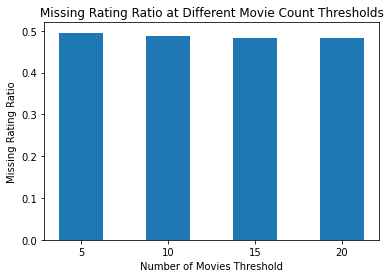

0    0.495583
1    0.486608
2    0.482610
3    0.482372
Name: Missing Ratio, dtype: float64

In [48]:
# Define the movie count thresholds
thresholds = [5, 10, 15, 20]

# Prepare the results dictionary
results = {'Threshold': [], 'Missing Ratio': []}

# Group the dataframe by 'ActorID' and count the number of movies per actor
movie_count_per_actor = characters_movies_renamed.groupby('ActorID').size()

# Loop over the defined thresholds
for threshold in thresholds:
    # Find actors that meet or exceed the threshold
    actors_meet_threshold = movie_count_per_actor[movie_count_per_actor >= threshold].index
    
    # Filter the dataframe to only include these actors
    filtered_df = characters_movies_renamed[characters_movies_renamed['ActorID'].isin(actors_meet_threshold)]
    
    # Calculate the missing ratio for 'averageRating'
    missing_ratio = filtered_df['AverageRating'].isna().sum() / len(filtered_df)
    
    # Add the results to the results dictionary
    results['Threshold'].append(threshold)
    results['Missing Ratio'].append(missing_ratio)

# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame(results)

# Plot the histogram
plt.bar(results_df['Threshold'], results_df['Missing Ratio'], width=2.5)
plt.xlabel('Number of Movies Threshold')
plt.ylabel('Missing Rating Ratio')
plt.title('Missing Rating Ratio at Different Movie Count Thresholds')
plt.xticks(thresholds)
plt.show()

results_df['Missing Ratio']

#### 3.3 Importing four dataset of actor awards from the four major film festivals

In [49]:
#Importing an organized dataset of actor awards in Cannes
award_columns = ['AwardYear', 'ActorName', 'CharacterName','MovieName']
Cannes = pd.read_csv(NEW_DATA_PATH+'Cannes.csv', sep=',')
Cannes.columns = award_columns
Cannes

,AwardYear,ActorName,CharacterName,MovieName
0,1946,Ray Milland,Don Birnam,The Lost Weekend
1,1949,Edward G. Robinson,Gino Monetti,House of Strangers
2,1951,Michael Redgrave,Andrew Crocker-Harris,The Browning Version
3,1952,Marlon Brando,Emiliano Zapata,Viva Zapata!
4,1955,Spencer Tracy,John J. Macreedy,Bad Day at Black Rock
...,...,...,...,...
177,2010,Juliette Binoche,The Woman,Certified Copy
178,2011,Kirsten Dunst,Justine,Melancholia
179,2012,Cristina Flutur,Alina,Beyond the Hills
180,2012,Cosmina Stratan,Voichita,Beyond the Hills


In [50]:
#Importing an organized dataset of actor awards in Berlin
Berlin = pd.read_csv(NEW_DATA_PATH+'Berlin.csv', sep=',')
Berlin.columns = award_columns
Berlin

,AwardYear,ActorName,CharacterName,MovieName
0,1956,Burt Lancaster,Mike Ribble,Trapeze
1,1957,Pedro Infante,Tizoc,Tizoc
2,1958,Sidney Poitier,Noah Cullen,The Defiant Ones
3,1959,Jean Gabin,Joseph Hughes Guillamume Boutier-Blainville / ...,Archimède le clochard
4,1960,Fredric March,Matthew Harrison Brady,Inherit The Wind
...,...,...,...,...
123,2011,Sareh Bayat,Razieh,A Separation
124,2011,Sarina Farhadi,Termeh,A Separation
125,2011,Kimia Hosseini,Somayeh,A Separation
126,2012,Rachel Mwanza,Komona,War Witch


In [51]:
#Importing an organized dataset of actor awards in Venice
Venice = pd.read_csv(NEW_DATA_PATH+'Venice.csv', sep=',')
Venice.columns = award_columns
Venice

,AwardYear,ActorName,CharacterName,MovieName
0,1932,Fredric March,Dr. Henry Jekyll / Mr. Edward Hyde,Dr. Jekyll and Mr. Hyde
1,1934,Wallace Beery,Pancho Villa,Viva Villa!
2,1935,Pierre Blanchar,Rodion Raskolnikov,Crime and Punishment
3,1936,Paul Muni,Louis Pasteur,The Story of Louis Pasteur
4,1937,Emil Jannings,Matthias Clausen,Der Herrscher
...,...,...,...,...
136,2009,Kseniya Rappoport,Sonia,The Double Hour
137,2010,Ariane Labed,Marina,Attenberg
138,2011,Deanie Ip,Sister Peach,A Simple Life
139,2012,Hadas Yaron,Shira Mendelman,Fill the Void


In [52]:
# Merge Cannes with main dataframe
Cannes_key = Cannes[['ActorName', 'MovieName']]
merged_awards_Cannes = pd.merge(characters_movies_renamed, Cannes_key, on=['ActorName', 'MovieName'], how='left', indicator='Cannes')
merged_awards_Cannes['Cannes'] = (merged_awards_Cannes['Cannes'] == 'both').astype(int)
merged_awards_Cannes.shape

(413660, 24)

In [53]:
# Merge Berlin with main dataframe
Berlin_key = Berlin[['ActorName', 'MovieName']]
merged_awards_Berlin = pd.merge(merged_awards_Cannes, Berlin_key, on=['ActorName', 'MovieName'], how='left', indicator='Berlin')
merged_awards_Berlin['Berlin'] = (merged_awards_Berlin['Berlin'] == 'both').astype(int)
merged_awards_Berlin.shape

(413660, 25)

In [54]:
# Merge Venice with main dataframe
Venice_key = Venice[['ActorName', 'MovieName']]
merged_awards_Venice = pd.merge(merged_awards_Berlin, Venice_key, on=['ActorName', 'MovieName'], how='left', indicator='Venice')
merged_awards_Venice['Venice'] = (merged_awards_Venice['Venice'] == 'both').astype(int)
merged_awards_Venice.shape

(413660, 26)

In [55]:
# Load Oscar Dataset 
Oscar = pd.read_csv(NEW_DATA_PATH+'the_oscar_award.csv', sep=',')
Oscar.head()

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False


In [56]:
#Dealing with irregularities in the Oscar dataset
selected_categories = ["ACTOR", "ACTRESS", "ACTOR IN A SUPPORTING ROLE", 
                       "ACTRESS IN A SUPPORTING ROLE", "ACTOR IN A LEADING ROLE", 
                       "ACTRESS IN A LEADING ROLE"]

selected_rows = Oscar[Oscar['category'].isin(selected_categories)].copy()


selected_rows['Oscar Winner'] = 0
selected_rows['Oscar Nomination'] = 0

selected_rows.loc[selected_rows['winner'], 'Oscar Winner'] = 1
selected_rows.loc[~selected_rows['winner'], 'Oscar Nomination'] = 1

Oscar_key = selected_rows[['name', 'film', 'Oscar Winner', 'Oscar Nomination']]
Oscar_key.columns = ['ActorName', 'MovieName', 'OscarWinner', 'OscarNomination' ]
Oscar_key.head()

,ActorName,MovieName,OscarWinner,OscarNomination
0,Richard Barthelmess,The Noose,0,1
1,Emil Jannings,The Last Command,1,0
2,Louise Dresser,A Ship Comes In,0,1
3,Janet Gaynor,7th Heaven,1,0
4,Gloria Swanson,Sadie Thompson,0,1


In [57]:
#merge Oscar dataset with our main set
merged_awards_Oscar = pd.merge(merged_awards_Venice, Oscar_key, on=['ActorName', 'MovieName'], how='left')
merged_awards_Oscar['OscarWinner'] = merged_awards_Oscar['OscarWinner'].fillna(0).astype(int)
merged_awards_Oscar['OscarNomination'] = merged_awards_Oscar['OscarNomination'].fillna(0).astype(int)
merged_awards_Oscar.shape

(413661, 28)

In [58]:
merged_awards_Oscar[merged_awards_Oscar["MovieGenresFinal"].isnull()]["MovieGenresFinal"]

Series([], Name: MovieGenresFinal, dtype: object)

## 4. Save as pkl file

In [59]:
# save the dataframe in a binary format
merged_awards_Oscar.to_pickle("./characters_movies.pkl")